In [74]:
%%capture
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from pandas_profiling import ProfileReport

import plotly.express as px

from category_encoders import OrdinalEncoder, OneHotEncoder

from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

from shap import TreeExplainer, initjs, force_plot

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, plot_roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier, XGBRegressor
 

DATA_PATH = 'C:/Users/Bryan Conn/Documents/GitHub/Build-Week-Unit-2/statisfaction_app/data/'

In [75]:
def wrangle(df):

    df = pd.read_csv(df,
                    index_col='id')

    df.drop('Unnamed: 0', axis=1, inplace= True)

    df['satisfaction'] = [1 if each == 'satisfied' else 0 for each in df.satisfaction]

    df.columns = [each.replace(" ", "_") for each in df.columns]

    df['Arrival_Delay_in_Minutes'] = df['Arrival_Delay_in_Minutes'].fillna(np.mean(df['Arrival_Delay_in_Minutes']))

    labels = ['1 to 5', '6 to 10', '11 to 15', '16 to 20', '21 to 25', '26 to 30', '31 to 35', '36 to 40', '41 to 45',
            '46 to 50', '51 to 55', '56 to 60', '61 to 65', '66 to 70', '71 to 75', '76 to 80']
            
    df['Age_Group'] = pd.cut(x= df['Age'], bins=range(0, 81, 5), labels= labels) 
    
    df.drop(columns=['Age', ], inplace=True)

    return df

df_train = wrangle(DATA_PATH + 'train.csv')
df_test = wrangle(DATA_PATH + 'test.csv')



# Data Visuals

<AxesSubplot:xlabel='satisfaction', ylabel='count'>

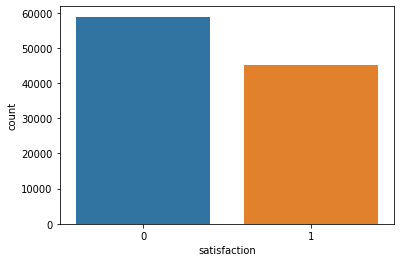

In [76]:
sns.countplot(x='satisfaction', data=df_train)

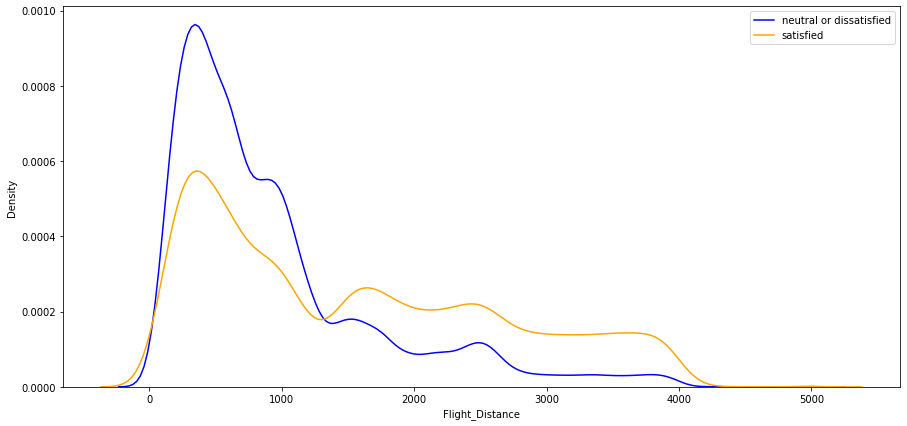

In [92]:
plt.figure(figsize= (15,7))
fig = sns.kdeplot(df_train.loc[df_train['satisfaction'] == 0, 'Flight_Distance'], label = 'neutral or dissatisfied', color='blue')
fig = sns.kdeplot(df_train.loc[df_train['satisfaction'] == 1, 'Flight_Distance'], label = 'satisfied', color='orange')
plt.legend();


In [78]:
df_train['Class'].unique()

array(['Eco Plus', 'Business', 'Eco'], dtype=object)

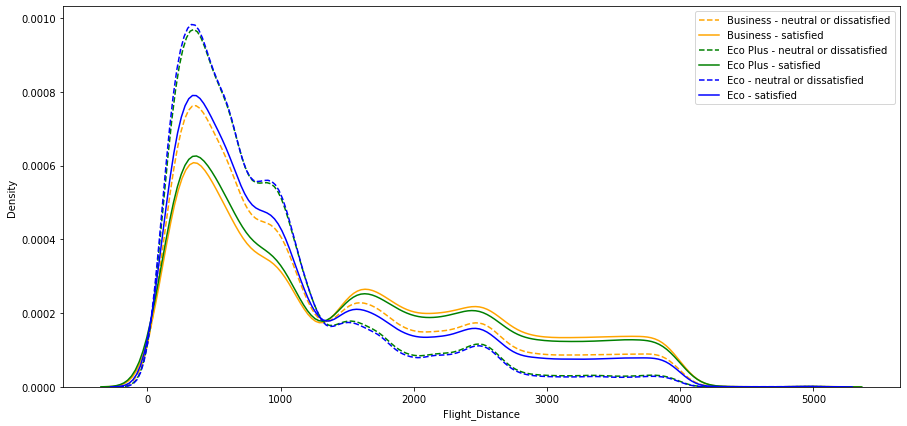

In [79]:
plt.figure(figsize = (15, 7))
fig = sns.kdeplot(df_train.loc[(df_train['satisfaction'] == 0) | (df_train['Class'] == 'Business') , 'Flight_Distance'], label="Business - neutral or dissatisfied", color='orange', linestyle='--');
fig = sns.kdeplot(df_train.loc[(df_train['satisfaction'] == 1) | (df_train['Class'] == 'Business') , 'Flight_Distance'], label="Business - satisfied", color='orange');
fig = sns.kdeplot(df_train.loc[(df_train['satisfaction'] == 0) | (df_train['Class'] == 'Eco Plus') , 'Flight_Distance'], label="Eco Plus - neutral or dissatisfied", color='green', linestyle='--');
fig = sns.kdeplot(df_train.loc[(df_train['satisfaction'] == 1) | (df_train['Class'] == 'Eco Plus') , 'Flight_Distance'], label="Eco Plus - satisfied", color='green');
fig = sns.kdeplot(df_train.loc[(df_train['satisfaction'] == 0) | (df_train['Class'] == 'Eco') , 'Flight_Distance'], label="Eco - neutral or dissatisfied", color='blue', linestyle='--');
fig = sns.kdeplot(df_train.loc[(df_train['satisfaction'] == 1) | (df_train['Class'] == 'Eco') , 'Flight_Distance'], label="Eco - satisfied", color='blue');

plt.legend();

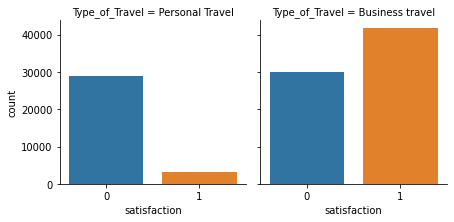

In [80]:
g = sns.catplot('satisfaction', col='Type_of_Travel', col_wrap=3, data=df_train, kind='count', height=3, aspect=1)


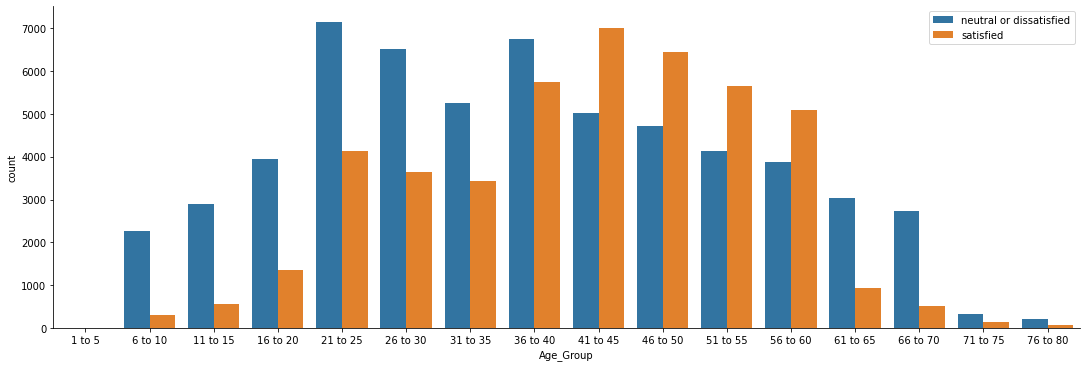

In [81]:

sns.catplot('Age_Group', data=df_train, aspect=3.0, kind='count', hue='satisfaction', legend=False)
plt.legend(labels=['neutral or dissatisfied', 'satisfied']);


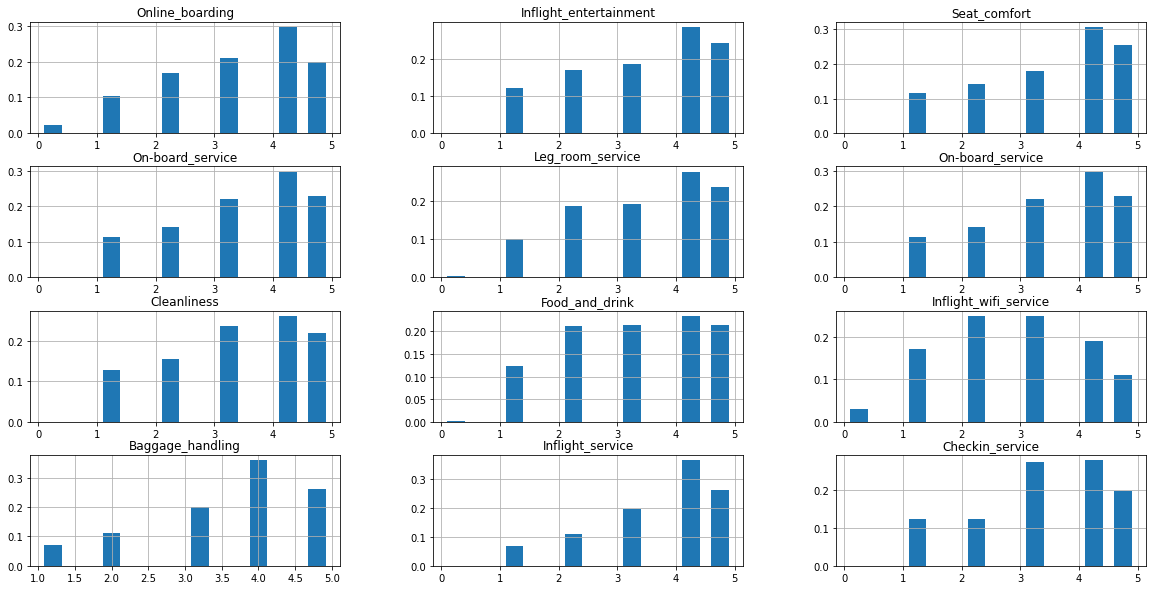

In [82]:
fig, axes = plt.subplots(4 , 3, figsize = (20, 10))

axes1 = df_train.hist('Online_boarding', weights=np.ones(len(df_train))/ len(df_train), ax= axes[0][0], rwidth = 0.6)
axes2 = df_train.hist('Inflight_entertainment', weights=np.ones(len(df_train))/ len(df_train), ax= axes[0][1], rwidth = 0.6)
axes3 = df_train.hist('Seat_comfort', weights=np.ones(len(df_train))/ len(df_train), ax= axes[0][2], rwidth = 0.6)
axes4 = df_train.hist('On-board_service', weights=np.ones(len(df_train))/ len(df_train), ax= axes[1][0], rwidth = 0.6)
axes5 = df_train.hist('Leg_room_service', weights=np.ones(len(df_train))/ len(df_train), ax= axes[1][1], rwidth = 0.6)
axes6 = df_train.hist('On-board_service', weights=np.ones(len(df_train))/ len(df_train), ax= axes[1][2], rwidth = 0.6)
axes7 = df_train.hist('Cleanliness', weights=np.ones(len(df_train))/ len(df_train), ax= axes[2][0], rwidth = 0.6)
axes8 = df_train.hist('Food_and_drink', weights=np.ones(len(df_train))/ len(df_train), ax= axes[2][1], rwidth = 0.6)
axes9 = df_train.hist('Inflight_wifi_service', weights=np.ones(len(df_train))/ len(df_train), ax= axes[2][2], rwidth = 0.6)
axes10 = df_train.hist('Baggage_handling', weights=np.ones(len(df_train))/ len(df_train), ax= axes[3][0], rwidth = 0.6)
axes11 = df_train.hist('Inflight_service', weights=np.ones(len(df_train))/ len(df_train), ax= axes[3][1], rwidth = 0.6)
axes12 = df_train.hist('Checkin_service', weights=np.ones(len(df_train))/ len(df_train), ax= axes[3][2], rwidth = 0.6)



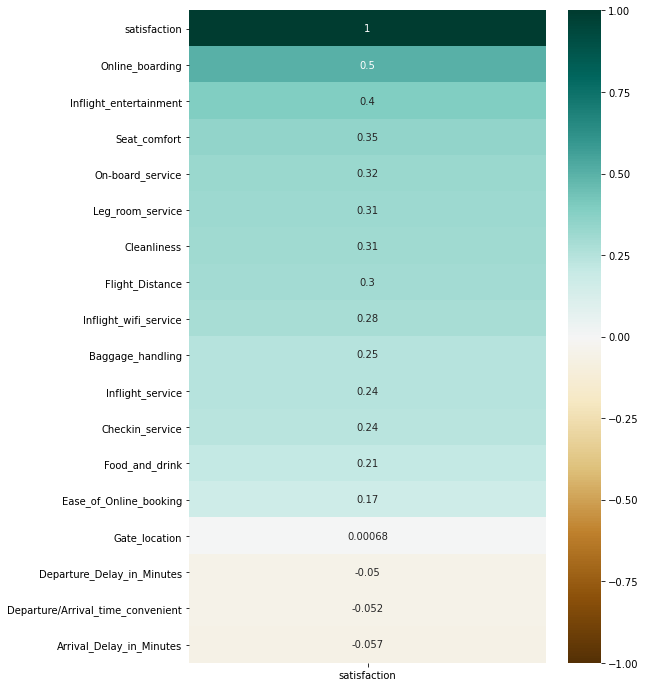

In [83]:
plt.figure(figsize= (8,12))
heatmap = sns.heatmap(df_train.corr()[['satisfaction']].sort_values(by= 'satisfaction', ascending=False), vmin=-1, vmax= 1, annot=True, cmap='BrBG')

** Because of very low correlation of Gate Location, Departure Delay, Arrival Delay, and Time Convenence, we drop this columns from our datasets**

In [84]:
df_train.drop(['Gate_location','Departure_Delay_in_Minutes', 'Arrival_Delay_in_Minutes', 'Departure/Arrival_time_convenient'], axis= 1, inplace=True)

df_test.drop(['Gate_location','Departure_Delay_in_Minutes', 'Arrival_Delay_in_Minutes', 'Departure/Arrival_time_convenient'], axis= 1, inplace=True)

# Split Data

### Establish Target

In [85]:
target = 'satisfaction'
y_train = df_train[target]
X_train = df_train.drop(columns= target, axis= 1)
test = df_test.drop(columns= target, axis= 1)
y_test = df_test[target]

**Baseline**

In [86]:
print('Baseline Accuracy: %',round(y_train.value_counts(normalize=True)*100,2))

Baseline Accuracy: % 0    56.67
1    43.33
Name: satisfaction, dtype: float64


In [22]:
y_train.value_counts(normalize=True)

0    0.566667
1    0.433333
Name: satisfaction, dtype: float64

# Logistic Regression

In [89]:
model_lr = make_pipeline(OrdinalEncoder(),
                        LogisticRegression(
                            C=3,
                            penalty= 'l2',
                            max_iter=150,
                            verbose=1,
                            random_state=42))
model_lr.fit(X_train,y_train);

print('Training Accuracy: %', round(model_lr.score(X_train,y_train)*100,2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Training Accuracy: % 83.38
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


TypeError: score() missing 1 required positional argument: 'X'

In [24]:
model_lr.score(X_train,y_train)

0.8337985063135201

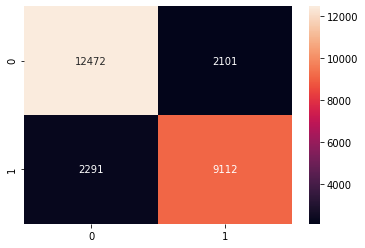

In [26]:
y_pred = model_lr.predict(test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt= 'd')
plt.show()


# Random Forest

In [27]:
model_dt = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(
        max_depth=19,
        min_samples_split=10,
        n_estimators= 300,
        n_jobs= -1,
        verbose= 1,
        random_state=42
    )
)
model_dt.fit(X_train, y_train);


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.8s finished


In [30]:
print(model_dt.score(X_train,y_train));

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
0.9753811210348013
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.3s finished


# Pickel Model

In [159]:
from joblib import dump

dump(model_dt, 'pipeline.joblib', compress=True)

['pipeline.joblib']

In [160]:
import joblib
import sklearn
import category_encoders as ce

print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={ce.__version__}')


joblib==1.0.1
scikit-learn==0.24.1
category_encoders==2.2.2


# Boosting

In [33]:
gb = make_pipeline(OrdinalEncoder(),
                    SimpleImputer(strategy='mean'),
                    GradientBoostingClassifier(learning_rate=0.1, n_estimators= 150, random_state= 42))

gb.fit(X_train, y_train);


In [34]:
print('Gradient Boosting Model Accuracy is', gb.score(X_train, y_train))

Gradient Boosting Model Accuracy is 0.948221435170927


In [35]:
xg = make_pipeline(OrdinalEncoder(),
                    SimpleImputer(strategy='mean'),
                    XGBClassifier(random_state= 42, n_jobs=10))

xg.fit(X_train, y_train);

[01:35:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [37]:
print('XGBoosting Model Accuracy is', xg.score(X_train, y_train))

XGBoosting Model Accuracy is 0.9711753156760087


Text(0.5, 0, 'Accuracy')

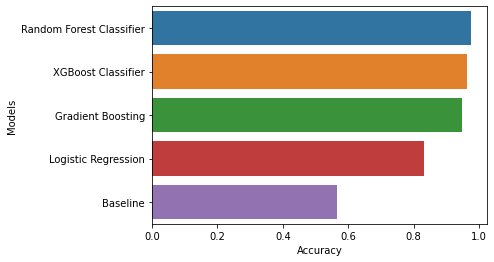

In [38]:
cv_results = pd.DataFrame({'Cross Validation Means': [0.9753811210348013, 0.9620418848167539, 0.9486449029873729, 0.831575300277179, 0.566667],
                            'Models': ['Random Forest Classifier', 'XGBoost Classifier', 'Gradient Boosting', 'Logistic Regression', 'Baseline']})

g = sns.barplot('Cross Validation Means', 'Models', data=cv_results)
plt.xlabel('Accuracy')
# g.set_ylabels('Cross Validation Scores')


In [41]:
print(accuracy_score(model_dt.predict(test),y_test))

0.9618878965198645
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.0s finished


# Permutation Importance

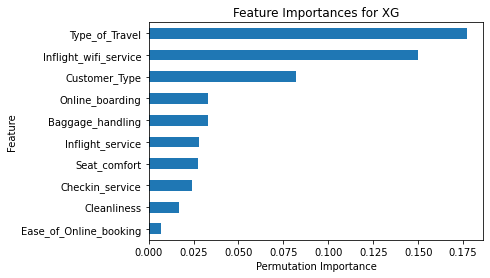

In [165]:
perm_imp = permutation_importance(xg,
                                  X_test,
                                  y_test,
                                  n_jobs= 10,
                                  random_state=42)

perm_data = pd.DataFrame({'importances_mean': perm_imp['importances_mean']}, index= X_test.columns)

perm_data['importances_mean'].sort_values().tail(10).plot(kind='barh')
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for XG');

# Shapley

In [166]:
row = X_test.iloc[[np.random.randint(1, len(X_test))]]
row

,Gender,Customer_Type,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Ease_of_Online_booking,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Age_Group
id,,,,,,,,,,,,,,,,,,
21955,Male,disloyal Customer,Business travel,Eco,551,2,2,5,2,5,5,4,1,2,1,2,5,21 to 25


In [167]:
oe = OrdinalEncoder()
X_train_T = oe.fit_transform(X_train)
gb2 = XGBRegressor(n_jobs=10)
gb2.fit(X_train_T, y_train);

In [168]:
gb2.predict(oe.transform(row))

array([-0.03670065], dtype=float32)

In [169]:
explainer = TreeExplainer(gb2)

initjs()

force_plot(base_value=explainer.expected_value,
            shap_values=explainer.shap_values(oe.transform(row)),
            features=row
)